In [1]:
import pandas as pd
import numpy as np
import re
import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import math
import seaborn as sns
from matplotlib import rc
import matplotlib.ticker as ticker
from dataclasses import dataclass
from scipy.stats import norm
from scipy import stats
import pypfopt as ppo

%matplotlib inline

# Setting the Context
## Probabilistic DCF valuation

To calculate the Free Cash Flow to Firm we use the below equation:

<img src="https://latex.codecogs.com/gif.download?%5Cinline%20FCFF%20%5C%3B%20%3D%20%5C%3B%20EBIT%20*%20%281-%20Effective%20Tax%29%20%5C%3B+%5C%3B%20Dep.%5C%3B%20and%20%5C%3B%20Amort.%5C%3B%20-%20%5C%3BChange%5C%3Bin%5C%3BNet%5C%3BWorking%5C%3BCapital-%5C%3BCAPEX">

To forecast the FCFF we need to forecast each element in the above equiation, and for do it automatically we need to introduce proxies for each item:

<img src="https://latex.codecogs.com/gif.latex?Reinvestment\;Rate&space;=&space;\;&space;\frac{CapEx\;-\;&space;Dep.\;and\;Amort.\;&plus;\;Changes&space;\;in\;WC}{EBIT\;&space;\times\;&space;(1\;&space;-\;&space;Eff.\;&space;Tax\;&space;Rate)}" title="Reinvestment\;Rate = \; \frac{CapEx\;-\; Dep.\;and\;Amort.\;+\;Changes \;in\;WC}{EBIT\; \times\; (1\; -\; Eff.\; Tax\; Rate)}" />


<img src="https://latex.codecogs.com/gif.latex?Return\;on\;Capital&space;=&space;\frac{EBIT\;&space;\times\;&space;(1\;&space;-\;&space;Eff.\;&space;Tax\;&space;Rate)}{Total\;Debt\;&plus;\;Total\;Equity}" title="Return\;on\;Capital = \frac{EBIT\; \times\; (1\; -\; Eff.\; Tax\; Rate)}{Total\;Debt\;+\;Total\;Equity}" />

and the internal growth rate will be : 

<img src="https://latex.codecogs.com/gif.latex?g\;=\;&space;Reinvestment\;Rate\;&space;\times\;&space;ROC" title="g\;=\; Reinvestment\;Rate\; \times\; ROC" />

first we need to extract the historical data for each proxy and we will assume that the future rates will oscillate around the historical mean and standard deviation. 


### Resources
https://www.youtube.com/watch?v=8gYT3Xgs6NE \
https://pages.stern.nyu.edu/~adamodar/ \
https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3237778


# Loading Data

In [2]:
path = '..\\Saputo Inc TSX SAP Financials.xls'
tickers = ['SAP.TO']
WACC = 0.062754
WACC_std = 0.0139884774

inc_df = pd.read_excel(path,
                      sheet_name='Income Statement', skiprows=14, index_col=0)
bs_df = pd.read_excel(path,
                         sheet_name='Balance Sheet', skiprows=14,index_col=0)
cf_df = pd.read_excel(path,
                         sheet_name='Cash Flow', skiprows=14,index_col=0)
Mult_df = pd.read_excel(path,
                         sheet_name='Multiples', skiprows=13,index_col=0)


WARNING *** file size (367626) not 512 + multiple of sector size (512)
WARNING *** file size (367626) not 512 + multiple of sector size (512)
WARNING *** file size (367626) not 512 + multiple of sector size (512)
WARNING *** file size (367626) not 512 + multiple of sector size (512)


# Data cleaning and calculation functions 

In [3]:
def StatementParser(df):
    date={}
    for i in range(len(df.columns)):
        if type(df.columns[i]) is str:
            match = re.search(r'\w{3}-\d{2}-\d{4}', str(df.columns[i]))
            date[str(df.columns[i])] = datetime.datetime.strptime(match.group(), '%b-%d-%Y').date()
        else:
            match = re.search(r'\d{4}-\d{2}-\d{2}', str(df.columns[i]))
            date[str(df.columns[i])] = datetime.datetime.strptime(match.group(), '%Y-%m-%d').date()
    df.rename(columns = date, inplace = True)
    df.replace(to_replace='-', value= 0 , inplace=True)
    df.dropna(how = 'all', inplace = True)
    df.drop('Currency', inplace = True)
    
    df = df.T
    df['Date'] = df.index
    df.set_index(df['Date'], inplace = True)
    df.drop('Date', axis=1, inplace = True)
    
    col={}
    for i in range(len(df.columns)):
        col[str(df.columns[i])] = str(str(df.columns[i]).lstrip())
    df.rename(columns = col, inplace = True)
    
    if df.index[-1].month != df.index[0].month:
        df.drop(df.tail(1).index , inplace=True)
    else:
        pass

    return df

def multiplesParser(df):
    a = df.loc[df.index == 'TEV/NTM EBIT'].T
    b = df.loc[df.index == 'TEV/LTM EBIT'].T
    c = df.loc[df.index == 'TEV/NTM EBITDA'].T
    d = df.loc[df.index == 'TEV/LTM EBITDA'].T
    mult = a.join(b.join(c.join(d))).T
    mult.drop(columns=mult.columns[0], inplace = True)
    mult.replace(to_replace = '-', value = np.nan, inplace = True)
    mult.replace(to_replace = 'NM', value = np.nan, inplace = True)    
    mult = mult.apply(pd.to_numeric)
    mult = mult.T
    return mult
    
def load_info(tickers):
    inf = [[0 for i in range(len(tickers))] for j in range(8)]
    for i in range(len(tickers)):
        info = yf.Ticker(tickers[i]).info
        inf[0][i] = info['longName']
        inf[1][i] = info['sector']
        inf[2][i] = info['marketCap']
        inf[3][i] = info['beta']
        inf[4][i] = info['returnOnAssets']
        inf[5][i] = info['returnOnEquity']
        inf[6][i] = info['enterpriseToRevenue']
        inf[7][i] = info['enterpriseToEbitda']
    inf_df = pd.DataFrame(data = [inf[0], inf[1], np.array(inf[2])/1000000000, inf[3], inf[4], inf[5], inf[6], inf[7]],
                         index = ['Name', 'Sector', 'Market Cap $B', 'Beta', 'ROA', 'ROE', 'EV/Revenue', 'EV/EBITDA'],
                         columns = tickers).T
    return inf, inf_df

## Loading Multiples

In [4]:
multiples = multiplesParser(Mult_df)

In [5]:
IS = StatementParser(inc_df)

In [6]:
BS = StatementParser(bs_df)

In [7]:
CF = StatementParser(cf_df)

In [8]:
info, info_df = load_info(tickers)
info_df

,Name,Sector,Market Cap $B,Beta,ROA,ROE,EV/Revenue,EV/EBITDA
SAP.TO,Saputo Inc.,Consumer Defensive,12.472266,0.572533,0.03598,0.07138,1.16,13.85


In [9]:
market_data = yf.download(tickers, period = 'max', interval = '1d')

[*********************100%***********************]  1 of 1 completed


# Looking at the Capital Structure

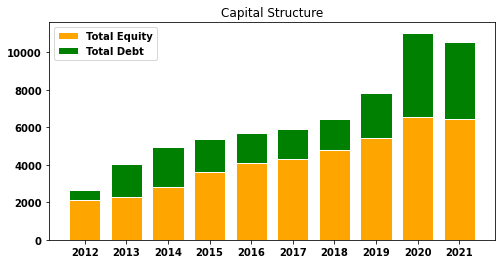

In [10]:
plt.figure(figsize=(8,4))
rc('font', weight = 'bold')
bars2 = BS['Total Debt']
bars1 = BS['Total Equity']

bars = np.add(bars1, bars2).tolist()

r = range(len(bars1))
 
names = BS.index.year
barWidth = 0.75

plt.bar(r, bars1, color='orange', edgecolor='white', width=barWidth, label = 'Total Equity')
plt.bar(r, bars2, bottom=bars1, color='green', edgecolor='white', width=barWidth, label = 'Total Debt')

plt.xticks(r, names, fontweight='bold')
plt.title("Capital Structure")
plt.legend()
plt.show()

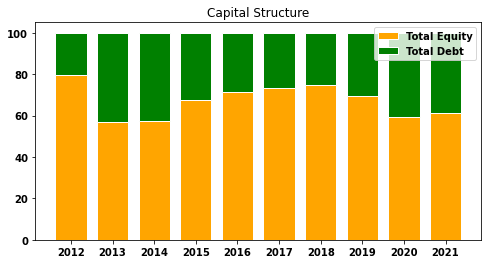

In [11]:
plt.figure(figsize=(8,4))
# Data
# r = []
raw_data = {'greenBars': BS['Total Debt'], 'orangeBars': BS['Total Equity']}
df = pd.DataFrame(raw_data)
 
# From raw value to percentage
totals = [i+j for i,j in zip(df['greenBars'], df['orangeBars'])]
greenBars = [i / j * 100 for i,j in zip(df['greenBars'], totals)]
orangeBars = [i / j * 100 for i,j in zip(df['orangeBars'], totals)]
 
# plot
barWidth = 0.75
# names = ()
# Create orange Bars (Equity)
plt.bar(r, orangeBars, color='orange', edgecolor='white', width=barWidth, label = 'Total Equity')
# Create green Bars (Debt)
plt.bar(r, greenBars, bottom=orangeBars, color='green', edgecolor='white', width=barWidth, label = 'Total Debt')
 
# Custom x axis
plt.xticks(r, names)
plt.title('Capital Structure')
 
# Show graphic
plt.legend(loc = 'upper right')
plt.show()


# Calculating the Fundamentals

In [12]:
revenue = IS['Revenue']
Chg_WC = CF['Change in Net Working Capital']
eff_tax = IS['Effective Tax Rate %'].replace('NM' , 0)
capex = abs(CF['Capital Expenditure'])
depreciation = CF['Depreciation & Amort., Total']
EBIT = IS['EBIT']
after_tax_EBIT = EBIT * (1 - eff_tax)
Reinv_rate = (capex - depreciation + Chg_WC) / (EBIT * (1 - eff_tax))
roc = (IS['EBIT'] * (1 - eff_tax)) / (BS['Total Debt'] + BS['Total Equity'])
g = (Reinv_rate * roc) 
fundamentals = pd.DataFrame(data = [revenue, Chg_WC, eff_tax, capex, depreciation, EBIT, after_tax_EBIT,
                                        Reinv_rate, roc, g],
                                index= [ 'Revenue','Change in Working Capital',
                                        'Effective Tax Rate', 'Capex', 'Depr. & Amort.', 'EBIT','EBIT (1-t)',
                                        'Reinvestment Rate', 'ROC', 'g']).T

Terminal_multiple = multiples['TEV/NTM EBIT'].mean()
terminalChanges = multiples['TEV/NTM EBIT'].std()
vwap_df = market_data[-252:]
vwap = round(np.average(vwap_df['Adj Close'], weights=vwap_df['Volume']),2)

In [13]:
fundamentals

,Revenue,Change in Working Capital,Effective Tax Rate,Capex,Depr. & Amort.,EBIT,EBIT (1-t),Reinvestment Rate,ROC,g
Date,,,,,,,,,,
2012-03-31,6930.370,105.370,0.342629,118.6,101.943,728.988,479.215571,0.254639,0.180687,0.046010
2013-03-31,7297.677,57.480,0.278309,178.2,116.629,744.143,537.041306,0.221679,0.132906,0.029462
2014-03-31,9232.889,258.075,0.296478,223.6,146.607,873.738,614.693905,0.545097,0.124402,0.067811
2015-03-31,10657.700,98.328,0.278856,186.9,170.900,890.800,642.395075,0.177971,0.119486,0.021265
2016-03-31,10991.500,144.400,0.309449,183.5,198.600,975.500,673.632500,0.191944,0.118156,0.022679
2017-03-31,11162.600,-47.400,0.297221,236.7,206.100,1082.200,760.547434,-0.022089,0.128543,-0.002839
2018-03-31,11542.500,174.700,0.102537,277.8,219.800,1038.400,931.925579,0.249698,0.145243,0.036267
2019-03-31,13501.900,337.300,0.233664,370.5,286.000,908.300,696.062989,0.605980,0.089031,0.053951
2020-03-31,14943.500,316.900,0.270862,509.9,440.100,1006.200,733.658656,0.527084,0.066426,0.035012


In [14]:
g.mean(), g.std()

(0.03082741193739456, 0.02238132299912822)

In [15]:
Terminal_multiple, terminalChanges

(15.046726274999994, 2.074180462186698)

# Running the Simulation

In [16]:
t_intervals = 10
iterations = 100000

In [17]:
values = []
for i in range(iterations):
    Expected_g = np.random.normal(np.mean(fundamentals['g']), np.std(fundamentals['g']), size = t_intervals)
    simWACC = np.random.normal(WACC, WACC_std, size= t_intervals)
    Reinvestment_rate = np.random.normal(np.mean(fundamentals['Reinvestment Rate']), np.std(fundamentals['Reinvestment Rate']), size = t_intervals)
    tax = np.random.normal(np.mean(fundamentals['Effective Tax Rate']), np.std(fundamentals['Effective Tax Rate']), size = t_intervals)
    change_in_working_capital = np.random.normal(np.mean(fundamentals['Change in Working Capital']), np.std(fundamentals['Change in Working Capital']), size = t_intervals)

    TerMulSim = np.random.normal(Terminal_multiple, terminalChanges)

    EBIT_E = []
    a = EBIT[-1]
    for i in range(t_intervals):
        a *= (1 + Expected_g[i])
        EBIT_E.append(a)

    after_tax_EBIT = (EBIT_E * (1 - tax))

    Capex_Dep = (after_tax_EBIT * Reinvestment_rate) - change_in_working_capital

    FCFF = after_tax_EBIT - change_in_working_capital - Capex_Dep

    discount_factor = []
    for i in range(t_intervals):
        if i == 0:
            i = 1 + simWACC[i]
            discount_factor.append(i)
        else:
            i = (1 + simWACC[i]) ** i
            discount_factor.append(i)

    PV = FCFF / discount_factor
    terminalValue = (EBIT_E[-1] * TerMulSim)
    PV_tV = terminalValue / ((1 + WACC) ** t_intervals)
    equityValue = PV.sum() + PV_tV - BS['Net Debt'][-1]
    sharesOutstanding = IS['Weighted Avg. Diluted Shares Out.'][-1]
    v = equityValue / sharesOutstanding
    values.append(v)



In [18]:
stock = round(market_data['Adj Close'][-1], 2)
stock

30.1

<ipython-input-19-f9eed391a0c7>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  sns.histplot(values, color='orange', label = 'Simulations').set_xticklabels(xlabels)


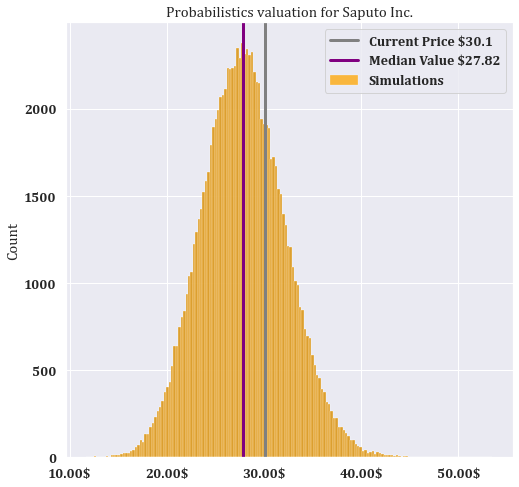

In [19]:
sns.set(rc={'figure.figsize':(8,8)})
sns.set(font_scale = 1.25, font = 'Cambria')
plt.axvline(x=stock, ymin=0,ymax=np.max(values), label = f'Current Price ${stock}', linewidth = 3, color = 'gray')
plt.axvline(x=np.median(values), ymin=0,ymax=np.max(values), label = f'Median Value ${round(np.median(values),2)}',
            linewidth = 3, color = 'purple')

xlabels = ['{:,.2f}'.format(x) + '$' for x in sns.histplot(values).get_xticks()]
sns.histplot(values, color='orange', label = 'Simulations').set_xticklabels(xlabels)
plt.title(label = f"Probabilistics valuation for {info[0][0]}")
plt.legend()
plt.show()

<ipython-input-20-9ce9dff44003>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  sns.ecdfplot(x=values, color = 'orange', label = 'Simulation CDF', linewidth = 4).set_xticklabels(xlabels)


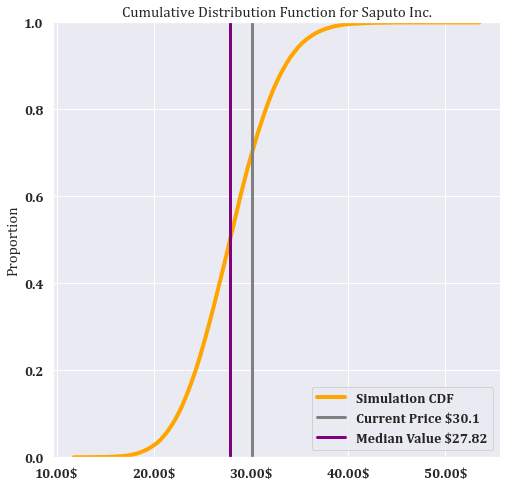

In [20]:
xlabels = ['{:,.2f}'.format(x) + '$' for x in sns.ecdfplot(x=values).get_xticks()]
sns.ecdfplot(x=values, color = 'orange', label = 'Simulation CDF', linewidth = 4).set_xticklabels(xlabels)
plt.axvline(x=stock, ymin=0,ymax=np.max(values), label = f'Current Price ${stock}', linewidth = 3, color = 'gray')
plt.axvline(x=np.median(values), ymin=0,ymax=np.max(values), label = f'Median Value ${round(np.median(values),2)}',
            linewidth = 3, color = 'purple')
plt.title(label = f"Cumulative Distribution Function for {info[0][0]}")

plt.legend()
plt.show()

In [21]:
Percentile_table = pd.DataFrame(data = [np.percentile(values, 0), np.percentile(values, 10), np.percentile(values, 20),
                                       np.percentile(values, 30), np.percentile(values, 40), np.percentile(values, 50),
                                       np.percentile(values, 60), np.percentile(values, 70), np.percentile(values, 80),
                                       np.percentile(values, 90), np.percentile(values, 100)],
                               index = ['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'],
                               columns = ['Values'])

Percentile_table.index.name = 'Percentiles'
Percentile_table

,Values
Percentiles,
0%,11.715794
10%,22.482610
20%,24.283847
30%,25.590767
40%,26.738328
50%,27.818650
60%,28.891029
70%,30.086906
80%,31.499046


In [22]:
valuation = pd.DataFrame(data = [datetime.datetime.now(),np.array(values).mean() - np.array(values).std(), 
                                np.array(values).mean(),
                                np.array(values).mean() + np.array(values).std(),
                                stock, vwap],
                        index = ['time','Worst Case', 'Base Case','Best Case', 'Market Price', 'VWAP'],
                        columns = tickers).T
valuation.index.name = 'Ticker'
valuation.to_csv('valuation.csv', mode = 'a')
valuation.round(2)

,time,Worst Case,Base Case,Best Case,Market Price,VWAP
Ticker,,,,,,
SAP.TO,2021-11-23 13:39:31.696154,23.621501,27.920291,32.219081,30.1,35.35


In [23]:
valu = pd.DataFrame(data = values, columns = tickers)

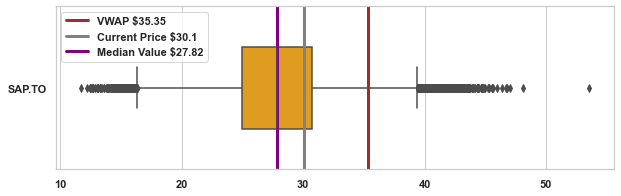

In [24]:
sns.set(rc={'figure.figsize':(10,3)})
sns.set_theme(style = 'whitegrid')
sns.boxplot(data = valu, orient='h', color = 'orange', width = 0.5)

plt.axvline(x=vwap, ymin=0,ymax=np.max(values), label = f'VWAP ${vwap}', linewidth = 3, color = 'brown')
plt.axvline(x=stock, ymin=0,ymax=np.max(values), label = f'Current Price ${stock}', linewidth = 3, color = 'gray')
plt.axvline(x=np.median(values), ymin=0,ymax=np.max(values), label = f'Median Value ${round(np.median(values),2)}',
            linewidth = 3, color = 'purple')
plt.legend(loc = 'upper left')

In [25]:
fcf_table = pd.DataFrame(data = [Reinvestment_rate, Expected_g, tax,
                                 EBIT_E, after_tax_EBIT, change_in_working_capital,
                                 Capex_Dep, FCFF, simWACC, discount_factor,PV],
                         index = ['Reinvestment Rate', 'Expected Growth',
                                   'Tax','EBIT','EBIT(1-t)',
                                  'Change in Working Capital', 'Capex - Depreciation',
                                  'FCFF', 'WACC','Discount Factor','PV']).T
fcf_table

,Reinvestment Rate,Expected Growth,Tax,EBIT,EBIT(1-t),Change in Working Capital,Capex - Depreciation,FCFF,WACC,Discount Factor,PV
0,0.518099,0.028388,0.231077,990.646516,761.730916,245.730262,148.921462,367.079191,0.085488,1.085488,338.169825
1,0.174396,0.035595,0.197679,1025.908686,823.107717,191.888040,-48.341425,679.561102,0.073313,1.073313,633.143328
2,0.183356,0.004277,0.266331,1030.296288,755.896384,131.369442,7.228983,617.297959,0.068548,1.141796,540.637789
3,0.491206,0.022024,0.343397,1052.987581,691.395179,110.819605,228.797576,351.777999,0.083744,1.272857,276.368890
4,0.349159,0.037900,0.263114,1092.895557,805.339400,373.562296,-92.370839,524.147943,0.088422,1.403427,373.477196
5,-0.207819,0.001105,0.249282,1094.102773,821.362521,286.515167,-457.209765,992.057119,0.044673,1.244234,797.323721
6,0.202786,0.028257,0.316605,1125.018302,768.831440,123.012017,32.896563,612.922860,0.034965,1.229005,498.714724
7,0.051187,0.038721,0.295899,1168.579603,822.798246,40.582567,1.533765,780.681914,0.044831,1.359322,574.317085
8,0.317634,0.043210,0.362841,1219.074481,776.744177,284.506989,-37.786758,530.023947,0.063419,1.635445,324.085449
9,0.446054,0.002748,0.215802,1222.424250,958.622397,283.704608,143.892572,531.025217,0.056466,1.639452,323.904030


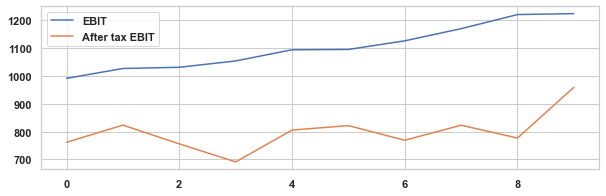

In [26]:
plt.plot(EBIT_E,label = 'EBIT')
plt.plot(after_tax_EBIT, label = 'After tax EBIT')
plt.legend()

In [27]:
s = market_data['Adj Close']
returns = ppo.expected_returns.mean_historical_return(s.values)
stdev = ppo.risk_models.risk_matrix(s, method='sample_cov')
# np.std(s.pct_change())
stats = pd.DataFrame(data = [returns.values[0], stdev.values[0][0]],
             index = ['Mean', 'StDev'], columns = tickers)
stats


C:\Users\nemat\AppData\Roaming\Python\Python38\site-packages\pypfopt\expected_returns.py:119: RuntimeWarning: prices are not in a dataframe
  warnings.warn("prices are not in a dataframe", RuntimeWarning)
C:\Users\nemat\AppData\Roaming\Python\Python38\site-packages\pypfopt\risk_models.py:165: RuntimeWarning: data is not in a dataframe
  warnings.warn("data is not in a dataframe", RuntimeWarning)


,SAP.TO
Mean,0.126456
StDev,0.063603


Text(0, 0.5, 'Cumulative Returns')

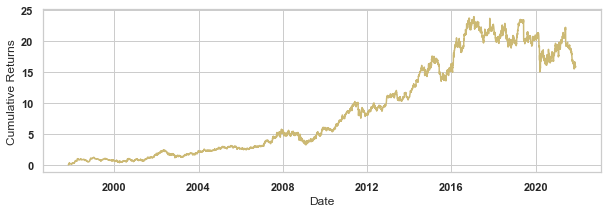

In [28]:
plt.plot((1 + s.pct_change()).cumprod() - 1, color = 'y')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')

Text(0, 0.5, 'Close Price')

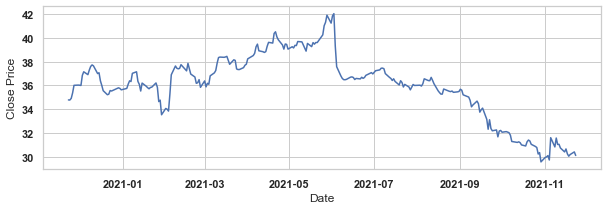

In [29]:
plt.plot(market_data['Close'][-(252):])
plt.xlabel('Date')
plt.ylabel('Close Price')